c:\Users\Bert\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Bert\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Bert\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Bert\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the 

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 511ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


c:\Users\Bert\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Bert\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


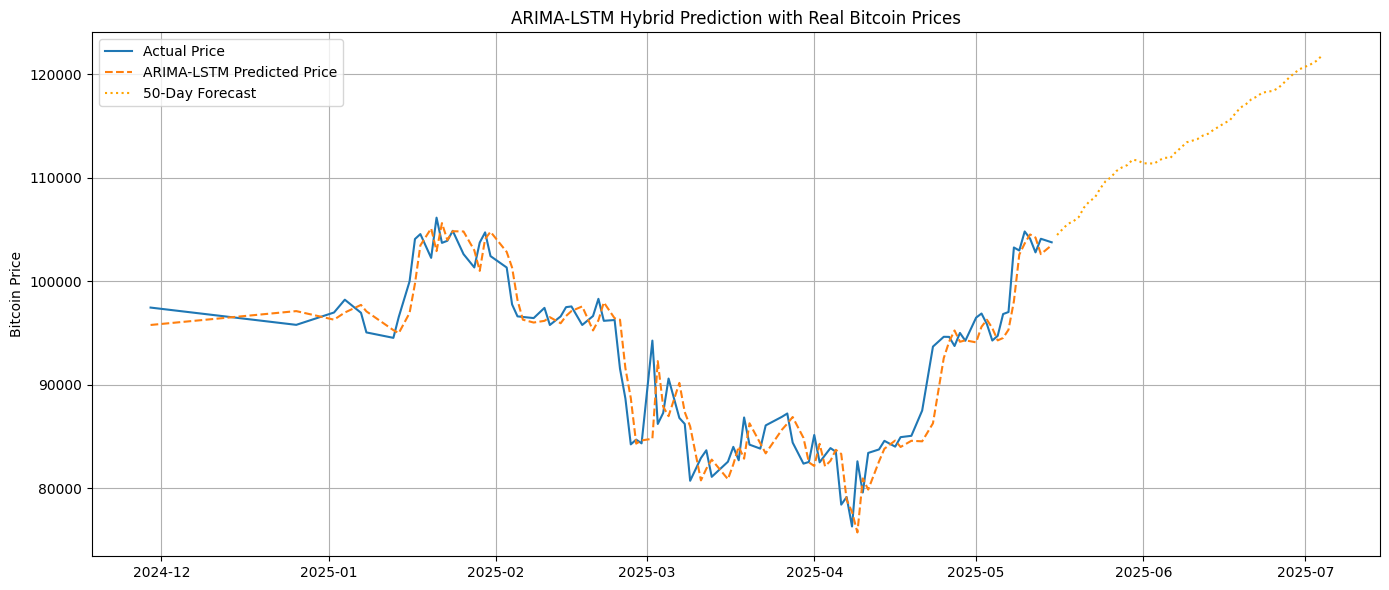

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load and preprocess data
df = pd.read_csv("bitcoin_sentiment_FinBERT.csv")
df['published_date'] = pd.to_datetime(df['published_date']).dt.normalize()
df.sort_values('published_date', inplace=True)

# Use actual BTC prices from dataset
df['price_btc'] = df['price_btc'].astype(float)

# Clean sentiment mapping
df['sentiment_score'] = df['sentiment_score'].astype(float)

# Aggregate by date
daily_df = df.groupby('published_date').agg({
    'sentiment_score': 'mean',
    'price_btc': 'mean'
}).reset_index()
daily_df.set_index('published_date', inplace=True)

# Fit ARIMA model
price_series = daily_df['price_btc']
arima_model = ARIMA(price_series, order=(1, 1, 1))
arima_result = arima_model.fit()
arima_pred = arima_result.predict(start=1, end=len(price_series)-1, typ='levels')
residuals = price_series[1:] - arima_pred

# Prepare features for LSTM
lstm_df = daily_df.iloc[1:].copy()
lstm_df['residual'] = residuals

# Normalize features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(lstm_df[['sentiment_score', 'residual']])

# Prepare sequences
X, y = [], []
seq_len = 5
for i in range(seq_len, len(scaled_features)):
    X.append(scaled_features[i-seq_len:i, 0:2])
    y.append(scaled_features[i, 1])
X, y = np.array(X), np.array(y)

# Build and train LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=100, batch_size=8, verbose=0)

# Predict residuals
predicted_residuals = model.predict(X)
temp = np.zeros((predicted_residuals.shape[0], 2))
temp[:, 1] = predicted_residuals[:, 0]
inv_residuals = scaler.inverse_transform(temp)[:, 1]

# Combine ARIMA + LSTM
final_arima = arima_pred.iloc[seq_len:].values
final_predicted_price = final_arima + inv_residuals

# Forecast future
future_days = 50
last_sentiment = daily_df['sentiment_score'].iloc[-1]

np.random.seed(42)
future_sentiments = [last_sentiment]
for _ in range(future_days - 1):
    next_val = future_sentiments[-1] + np.random.normal(0, 0.1)
    future_sentiments.append(np.clip(next_val, -1, 1))
future_sentiments = np.array(future_sentiments)

future_arima = arima_result.forecast(steps=future_days)

future_X = []
last_scaled = scaled_features[-seq_len:].copy()
for sentiment in future_sentiments:
    new_input = last_scaled.copy()
    new_input[:-1] = new_input[1:]
    new_input[-1, 0] = sentiment
    new_input[-1, 1] = 0
    future_X.append(new_input)
    last_scaled = new_input

future_X = np.array(future_X)
future_residuals = model.predict(future_X)

temp_future = np.zeros((future_residuals.shape[0], 2))
temp_future[:, 1] = future_residuals[:, 0]
inv_future_residuals = scaler.inverse_transform(temp_future)[:, 1]
future_price_pred = future_arima + inv_future_residuals

# Dates for forecast
last_date = daily_df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days, freq='D')

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(price_series.index[seq_len+1:], price_series.values[seq_len+1:], label='Actual Price')
plt.plot(price_series.index[seq_len+1:], final_predicted_price, label='ARIMA-LSTM Predicted Price', linestyle='--')
plt.plot(future_dates, future_price_pred, label='50-Day Forecast', linestyle=':', color='orange')
plt.title("ARIMA-LSTM Hybrid Prediction with Real Bitcoin Prices")
plt.ylabel("Bitcoin Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Validation in Traning

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0105 - val_loss: 0.0062
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0062 - val_loss: 0.0061
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0067 - val_loss: 0.0049
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0063 - val_loss: 0.0069
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - val_loss: 0.0060
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0062 - val_loss: 0.0049
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0066 - val_loss: 0.0070
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0075 - val_loss: 0.0060
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0084 - val_loss: 0.0056
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0077 - val_loss: 0.0062
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0057 - val_loss: 0.0058
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step -

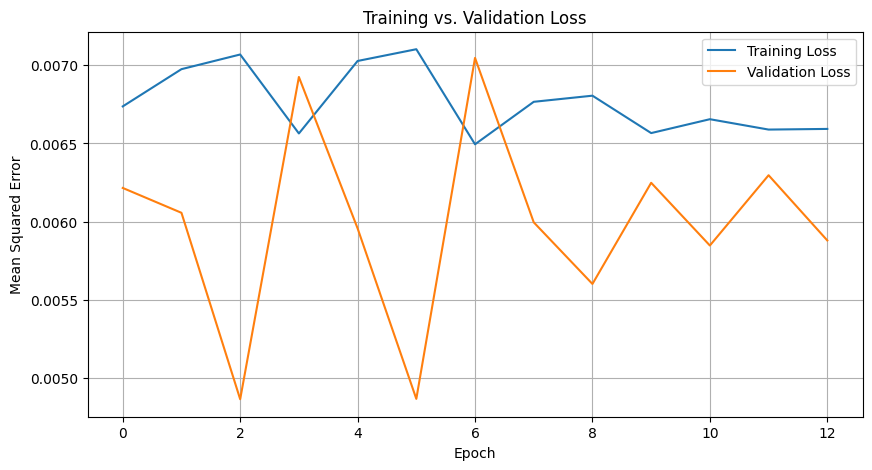

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Add EarlyStopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with validation split
history = model.fit(
    X, y,
    epochs=100,
    batch_size=8,
    validation_split=0.2,  # 20% of data for validation
    callbacks=[early_stop],
    verbose=1
)
# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
for epoch, (train_loss, val_loss) in enumerate(zip(history.history['loss'], history.history['val_loss']), 1):
    print(f"Epoch {epoch}: Training Loss = {train_loss:.6f}, Validation Loss = {val_loss:.6f}")


Epoch 1: Training Loss = 0.006737, Validation Loss = 0.006215
Epoch 2: Training Loss = 0.006975, Validation Loss = 0.006056
Epoch 3: Training Loss = 0.007069, Validation Loss = 0.004863
Epoch 4: Training Loss = 0.006564, Validation Loss = 0.006925
Epoch 5: Training Loss = 0.007028, Validation Loss = 0.005957
Epoch 6: Training Loss = 0.007103, Validation Loss = 0.004865
Epoch 7: Training Loss = 0.006495, Validation Loss = 0.007047
Epoch 8: Training Loss = 0.006767, Validation Loss = 0.005995
Epoch 9: Training Loss = 0.006806, Validation Loss = 0.005601
Epoch 10: Training Loss = 0.006566, Validation Loss = 0.006248
Epoch 11: Training Loss = 0.006655, Validation Loss = 0.005847
Epoch 12: Training Loss = 0.006589, Validation Loss = 0.006297
Epoch 13: Training Loss = 0.006593, Validation Loss = 0.005879


In [14]:
print("Price data sample:")
print(daily_df['price_btc'].head(10))

print("\nARIMA predicted sample:")
print(arima_pred.head(10))

print("\nFinal predicted price sample:")
print(final_predicted_price[:10])

print("\nFuture predicted price sample:")
print(future_price_pred[:10]) # future_price_pred --> eto ung guide mo for getting the predicted price per day.


Price data sample:
published_date
2024-02-12    49917.27
2024-06-11    67314.24
2024-11-16    90586.92
2024-11-17    89855.99
2024-11-23    97672.40
2024-11-26    91965.16
2024-11-29    97460.00
2024-12-26    95791.60
2025-01-02    96984.79
2025-01-04    98220.50
Name: price_btc, dtype: float64

ARIMA predicted sample:
published_date
2024-06-11    50281.907099
2024-11-16    67810.145981
2024-11-17    91257.023809
2024-11-23    90515.392561
2024-11-26    98385.666612
2024-11-29    92630.341445
2024-12-26    98160.968809
2025-01-02    96475.042573
2025-01-04    97671.895478
2025-01-07    98911.523169
Name: predicted_mean, dtype: float64

Final predicted price sample:
[95779.81857842 97119.04780077 96291.78717335 96980.73360329
 97717.43544012 97092.97608171 95281.13576575 94995.06315552
 96939.5990522  99771.80215765]

Future predicted price sample:
106    104469.229541
107    105025.078235
108    105541.377138
109    105785.096385
110    106185.597741
111    107126.320757
112    107719.

# Sentiment - Record (Values)

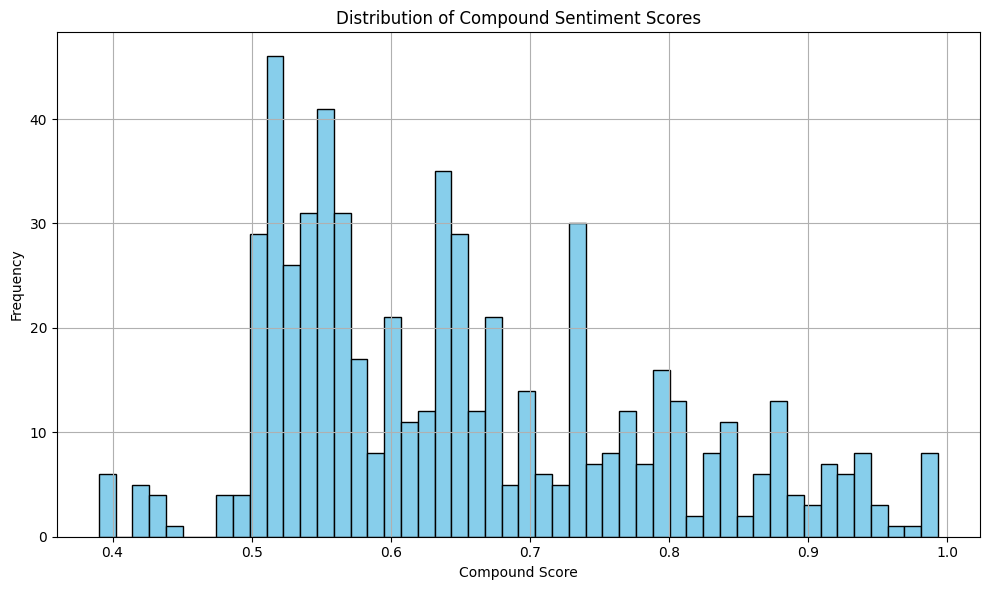

In [15]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt


# Load dataset
df = pd.read_csv("bitcoin_sentiment_FinBERT.csv")

# Plotting the sentiment score distribution
plt.figure(figsize=(10, 6))
plt.hist(df['sentiment_score'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Compound Sentiment Scores')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()
# Optionally, save the updated DataFrame


#df.to_csv("bitcoin_sentiment_scored.csv", index=False)

In [16]:
print(df['price_btc'])


0       49917.27
1       67314.24
2       67314.24
3       90586.92
4       89855.99
         ...    
595     83680.12
596     83680.12
597    102791.32
598    102791.32
599    102791.32
Name: price_btc, Length: 600, dtype: float64


# Metric Scores

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# True and predicted values for evaluation (excluding forecast)
true_values = price_series.values[seq_len+1:]
predicted_values = final_predicted_price

# Evaluation metrics
mae = mean_absolute_error(true_values, predicted_values)
rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
r2 = r2_score(true_values, predicted_values)
mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
pseudo_accuracy = 100 - mape



# Print the scores
print("Model Evaluation Metrics:")
print(f"MAE (Mean Absolute Error): {mae:.6f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.6f}")
print(f"R² Score: {r2:.6f}")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
print(f"Pseudo Accuracy: {pseudo_accuracy:.2f}%")


Model Evaluation Metrics:
MAE (Mean Absolute Error): 1887.408272
RMSE (Root Mean Squared Error): 2529.615792
R² Score: 0.899772
MAPE (Mean Absolute Percentage Error): 2.07%
Pseudo Accuracy: 97.93%


# Heatmap Correlation

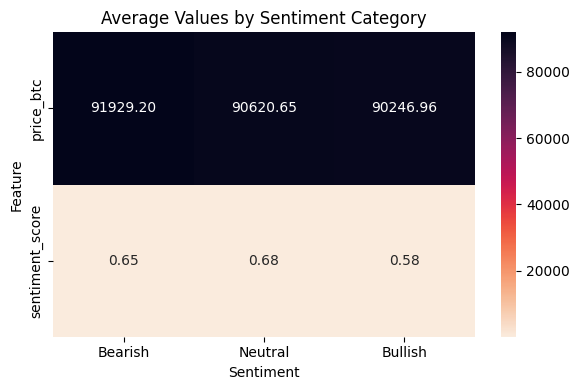

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create pivot table: rows = numerical variables, columns = sentiment categories
heatmap_data = df.groupby('sentiment_label')[['price_btc', 'sentiment_score']].mean().T

# Optional: order columns if needed
heatmap_data = heatmap_data[['Bearish', 'Neutral', 'Bullish']]

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(heatmap_data, annot=True, cmap='rocket_r', fmt=".2f")
plt.title("Average Values by Sentiment Category")
plt.xlabel("Sentiment")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


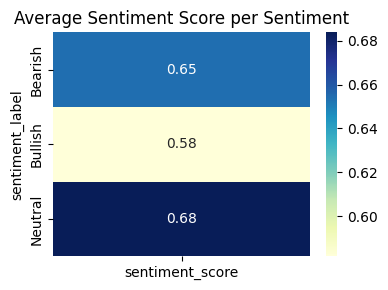

In [21]:
# Pivot the sentiment and Sentiment for heatmap
pivot_df = df.groupby('sentiment_label')['sentiment_score'].mean().reset_index()

# Reshape for heatmap
pivot_df = pivot_df.pivot_table(values='sentiment_score', index='sentiment_label')

# Plot heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Average Sentiment Score per Sentiment")
plt.tight_layout()
plt.show()
